In [16]:
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import os
import mlflow

# Optimisations de TensorFlow sur macOS
os.environ["TF_METAL_DISABLE_RENDER_COMPOSITOR"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

warnings.filterwarnings("ignore")

# Définition du modèle VGG
image_resize = 224
my_VGG = Sequential()


In [3]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

## test sur le modéle VGG16

In [4]:
# Définition de la forme des images d'entrée (hauteur, largeur, canaux de couleur)
img_shape = (224, 224, 3)

# Chargement du modèle pré-entraîné VGG16 sans les couches de classification finales
# - `input_shape` : spécifie la taille des images d'entrée
# - `include_top=False` : exclut les couches de classification du haut du modèle
# - `weights='imagenet'` : utilise les poids pré-entraînés sur le dataset ImageNet
model_VGG16 = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

# Affiche un résumé de l'architecture du modèle, y compris les couches et le nombre de paramètres
model_VGG16.summary()

2025-05-26 14:59:29.789859: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-26 14:59:29.790247: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-26 14:59:29.790258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-26 14:59:29.790541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 14:59:29.790579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# adapter le modèle pour correspondre a nos besoins
model_VGG16.trainable = False

In [6]:
# Renvoie la sortie brute du modèle VGG16
# Cette sortie correspond au tenseur produit par la dernière couche du modèle
# pré-entraîné VGG16, sans les couches de classification finales (car include_top=False).
model_VGG16.output

<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, ragged=False, name=keras_tensor_18>

In [7]:
# Modifier la couche de sorties
x = Flatten()(model_VGG16.output)  # Aplatissement des sorties du modèle VGG16
prediction = Dense(1, activation='sigmoid')(x)  # Couche de sortie avec activation sigmoid pour classification binaire

In [8]:
# Création du modèle final en spécifiant les entrées et sorties
# - `inputs=model_VGG16.input` : Utilise les entrées du modèle VGG16 pré-entraîné
# - `outputs=prediction` : Définit la sortie comme la couche personnalisée ajoutée
model = Model(inputs=model_VGG16.input, outputs=prediction)

# Affiche un résumé de l'architecture du modèle, y compris les couches et le nombre de paramètres
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Compilation du modèle
# - `loss='categorical_crossentropy'` : Fonction de perte utilisée pour des problèmes de classification multi-classes.
# - `optimizer='adam'` : Optimiseur adaptatif efficace pour la descente de gradient.
# - `metrics=['accuracy']` : Métrique utilisée pour évaluer la performance du modèle.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur pour les données d'entraînement avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels
    shear_range=0.2,  # Transformation de cisaillement
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True  # Inversion horizontale
)

# Générateur pour les données de test (sans augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement

# Chargement des données d'entraînement
training_set = train_datagen.flow_from_directory(
    "chest_xray/train",  # Répertoire des données d'entraînement
    target_size=(224, 224),  # Redimensionnement des images
    batch_size=32,  # Taille des lots
    class_mode='binary'  # Classification binaire
)

# Chargement des données de test
test_set = test_datagen.flow_from_directory(
    "chest_xray/test",  # Répertoire des données de test
    target_size=(224, 224),  # Redimensionnement des images
    batch_size=32,  # Taille des lots
    class_mode='binary'  # Classification binaire
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Importation des bibliothèques nécessaires
import mlflow  # Bibliothèque de suivi des expériences de Machine Learning
import mlflow.keras  # Intégration de MLflow avec Keras
import matplotlib.pyplot as plt  # Pour la visualisation des résultats
import numpy as np  # Opérations sur les matrices et tableaux
import tensorflow as tf  # Bibliothèque principale de deep learning
from tensorflow.keras.models import Model  # Classe de modèles personnalisés
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Couches utilisées pour construire le modèle

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier Adaptatif")  # Définition du nom de l'expérience MLflow

# Définition des hyperparamètres initiaux
epochs = 15  # Nombre total d'époques d'entraînement
batch_size = 15  # Nombre d'échantillons utilisés par lot
dense_units = 128  # Nombre initial de neurones dans les couches denses
dropout_rate = 0.5  # Taux de dropout pour éviter le sur-apprentissage
target_accuracy = 0.95  # Seuil de précision cible pour arrêter l'ajout de nouvelles couches

# Définition du modèle initial basé sur VGG16
base_model = model_VGG16  # Chargement du modèle pré-entraîné VGG16
base_model.trainable = False  # On gèle les poids pour ne pas les modifier durant l'entraînement

# Ajout de couches au modèle pré-entraîné
x = Flatten()(base_model.output)  # Transformation des données en un vecteur plat
x = Dense(dense_units, activation="relu")(x)  # Première couche dense avec activation ReLU
x = Dropout(dropout_rate)(x)  # Ajout d'un dropout pour limiter le sur-apprentissage
prediction = Dense(1, activation="sigmoid")(x)  # Couche de sortie pour une classification binaire
model = Model(inputs=base_model.input, outputs=prediction)  # Création du modèle final

# Compilation du modèle avec la fonction de coût et l'optimiseur
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Démarrage du suivi MLflow pour enregistrer les résultats de l'expérience
with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):

    for epoch in range(epochs):  # Boucle à travers chaque époque d'entraînement
        # Entraînement du modèle pour une seule époque
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            epochs=1, batch_size=batch_size, verbose=1)

        # Récupérer les précisions obtenues
        val_accuracy = history.history["val_accuracy"][0]  # Précision sur les données de validation
        train_accuracy = history.history["accuracy"][0]  # Précision sur les données d'entraînement

        # Enregistrement des métriques dans MLflow
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # Vérification si la précision sur les données de validation est insuffisante
        if val_accuracy < target_accuracy:
            dense_units += 64  # Augmentation du nombre de neurones
            print(f"🔁 Ajout de neurones à l'époque {epoch+1}, total neurones : {dense_units}")

            # Création d'une nouvelle couche dense et dropout
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)

            # Transformation du modèle pour lui permettre l'ajout dynamique de nouvelles couches
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])

            # Compilation du nouveau modèle
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"✅ Précision atteinte à l'époque {epoch+1}, poursuite sans modification")

    # Enregistrement des paramètres et du modèle final dans MLflow
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")


Expérience 'VGG16 Classifier Adaptatif test' existante, utilisation de l'ID 313186046198404367.
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.7486 - loss: 3.6530 - val_accuracy: 0.8269 - val_loss: 2.1051
Ajout de neurones à l'époque 1, total neurones : 192
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 95ms/step - accuracy: 0.7374 - loss: 0.4621 - val_accuracy: 0.8958 - val_loss: 0.4553
Ajout de neurones à l'époque 2, total neurones : 256
348/348 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.7133 - loss: 0.4984 - val_accuracy: 0.6250 - val_loss: 1.0032
Ajout de neurones à l'époque 3, total neurones : 320
348/348 ━━━━━━━━━━━━━━━━━━━━ 39s 77ms/step - accuracy: 0.7604 - loss: 0.4733 - val_accuracy: 0.8526 - val_loss: 0.5532
Ajout de neurones à l'époque 4, total neurones : 384
348/348 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.7625 - loss: 0.4511 - val_accuracy: 0.7083 - val_loss: 0.7595
Ajout de neurones à l'époque 5, total neurones : 448
348/348 ━━━━━━━━━━━━━━━━━━━━ 42s 110ms/step

2025/05/26 16:03:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Accuracy sur test : 0.3750
Loss sur test : 0.7010


2025/05/26 16:03:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


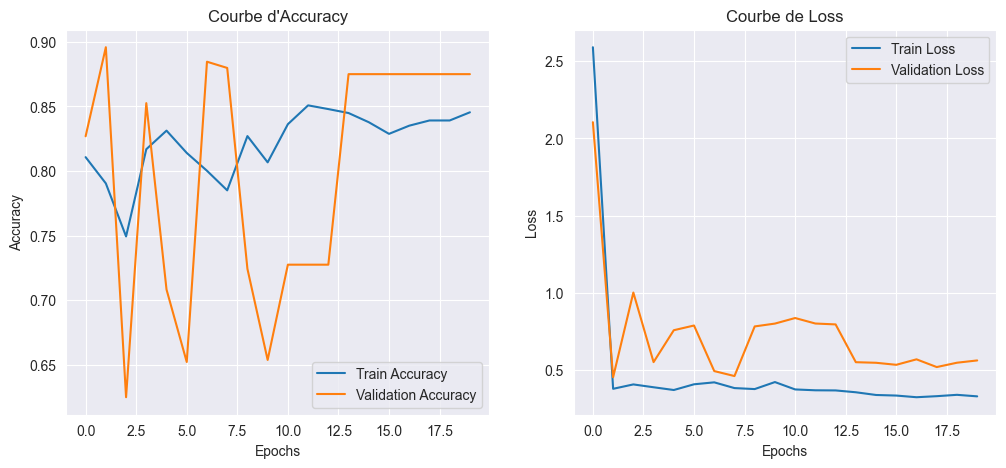

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step


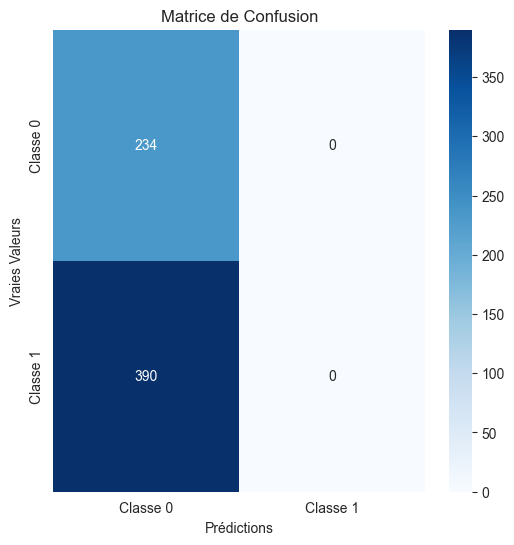

Meilleure précision atteinte : 0.8958
Perte minimale atteinte : 0.4553


In [27]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Définition du nom de l'expérience MLflow
experiment_name = "VGG16 Classifier Adaptatif test"
client = mlflow.tracking.MlflowClient()  # Création d'un client pour interagir avec MLflow

# Vérifier si l'expérience existe déjà
existing_experiments = client.search_experiments()
experiment_id = None

# Recherche d'une expérience MLflow existante
for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Création de l'expérience si elle n'existe pas encore
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Expérience '{experiment_name}' créée.")
else:
    print(f"Expérience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# Définir l'expérience active dans MLflow
mlflow.set_experiment(experiment_name)

# Paramètres du modèle
epochs = 20  # Nombre total d'époques d'entraînement
batch_size = 15  # Taille des mini-lots de données
dense_units = 128  # Nombre initial de neurones dans les couches denses
dropout_rate = 0.5  # Taux de dropout pour éviter le sur-apprentissage
target_accuracy = 0.95  # Précision cible pour ajuster dynamiquement le modèle

# Définition du modèle initial basé sur VGG16
base_model = model_VGG16  # Chargement du modèle pré-entraîné VGG16
base_model.trainable = False  # Gel des poids du modèle pré-entraîné

# Ajout de couches au modèle pré-entraîné
x = Flatten()(base_model.output)  # Transformation des données en vecteur plat
x = Dense(dense_units, activation="relu")(x)  # Ajout d'une couche dense avec activation ReLU
x = Dropout(dropout_rate)(x)  # Ajout d'un dropout pour éviter le sur-apprentissage
prediction = Dense(1, activation="sigmoid")(x)  # Couche de sortie pour la classification binaire
model = Model(inputs=base_model.input, outputs=prediction)  # Création du modèle final

# Compilation du modèle avec une fonction de coût et un optimiseur
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Dictionnaire pour stocker l'évolution des performances
history_data = {"train_accuracy": [], "val_accuracy": [], "train_loss": [], "val_loss": []}

# Démarrer l'enregistrement de l'expérience MLflow
with mlflow.start_run(run_name=f"VGG16 Dynamique {epochs} epochs, {batch_size} batch"):
    for epoch in range(epochs):  # Boucle d'entraînement sur plusieurs époques
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size, verbose=1)

        # Extraction des performances
        val_accuracy = history.history["val_accuracy"][0]  # Précision sur les données de validation
        train_accuracy = history.history["accuracy"][0]  # Précision sur les données d'entraînement
        val_loss = history.history["val_loss"][0]  # Perte sur les données de validation
        train_loss = history.history["loss"][0]  # Perte sur les données d'entraînement

        # Stocker les données pour les graphiques
        history_data["train_accuracy"].append(train_accuracy)
        history_data["val_accuracy"].append(val_accuracy)
        history_data["train_loss"].append(train_loss)
        history_data["val_loss"].append(val_loss)

        # Enregistrer les performances dans MLflow
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_accuracy)
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", train_accuracy)

        # Vérifier si le modèle doit être ajusté dynamiquement
        if val_accuracy < target_accuracy:
            dense_units += 64  # Augmenter le nombre de neurones
            print(f"Ajout de neurones à l'époque {epoch+1}, total neurones : {dense_units}")

            # Ajouter dynamiquement une couche
            new_layer = Dense(dense_units, activation="relu")
            dropout_layer = Dropout(dropout_rate)
            model = tf.keras.Sequential([model, new_layer, dropout_layer, Dense(1, activation="sigmoid")])
            model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        else:
            print(f"Précision atteinte à l'époque {epoch+1}, poursuite sans modification")

    # Évaluation finale
    test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
    mlflow.log_metric("final_test_accuracy", test_accuracy)
    mlflow.log_metric("final_test_loss", test_loss)

    # Enregistrement du modèle et des paramètres finaux
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("dense_units_final", dense_units)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.keras.log_model(model, "VGG16_Dynamique")

# Génération des graphiques de performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_data["train_accuracy"], label="Train Accuracy")
plt.plot(history_data["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe d'Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_data["train_loss"], label="Train Loss")
plt.plot(history_data["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe de Loss")
plt.legend()

plt.show()

# Matrice de confusion
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Valeurs")
plt.title("Matrice de Confusion")
plt.show()

# Calcul des meilleures performances atteintes
max_accuracy = max(history_data["val_accuracy"])
min_loss = min(history_data["val_loss"])

print(f"Meilleure précision atteinte : {max_accuracy:.4f}")
print(f"Perte minimale atteinte : {min_loss:.4f}")

# Enregistrement des meilleures performances
mlflow.log_metric("max_validation_accuracy", max_accuracy)
mlflow.log_metric("min_validation_loss", min_loss)


In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Récupérer les valeurs de l'historique
epochs = range(1, len(history.history['loss']) + 1)
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Création du graphique
plt.figure(figsize=(10, 5))

# Courbe de la loss
plt.plot(epochs, loss, 'r-', label="Loss (train)")
plt.plot(epochs, val_loss, 'r--', label="Loss (val)")

# Courbe de l'accuracy
plt.plot(epochs, accuracy, 'b-', label="Accuracy (train)")
plt.plot(epochs, val_accuracy, 'b--', label="Accuracy (val)")

# Personnalisation du graphique
plt.xlabel("Époques")
plt.ylabel("Valeurs")
plt.title("Évolution de l'accuracy et du loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Importation de la matrice de confusion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur les données de test
y_pred_proba = model.predict(X_test)

# Conversion des probabilités en classes (si softmax ou sigmoid)
y_pred = np.argmax(y_pred_proba, axis=1)  # pour softmax multi-classes
# y_pred = (y_pred_proba > 0.5).astype(int)  # pour binaire (sigmoid)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
import mlflow
import mlflow.keras
import matplotlib.pyplot as plt
import numpy as np
from mlflow.models import infer_signature

# Extraction des meilleures métriques de l'entraînement
meilleure_accuracy_train = max(history.history["accuracy"])
meilleure_accuracy_val = max(history.history["val_accuracy"])
min_loss = min(history.history["loss"])

# Initialisation du suivi MLflow
mlflow.set_experiment("VGG16 Classifier 1")

with mlflow.start_run(run_name="VGG16 Classifier"):

    # Enregistrement des hyperparamètres
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)

    # Enregistrement des métriques finales
    mlflow.log_metric("final_train_accuracy", meilleure_accuracy_train)
    mlflow.log_metric("final_val_accuracy", meilleure_accuracy_val)
    mlflow.log_metric("min_loss", min_loss)

    # Enregistrement des métriques par époque
    for epoch, acc in enumerate(history.history["accuracy"]):
        mlflow.log_metric(f"train_accuracy_epoch_{epoch+1}", acc)

    for epoch, val_acc in enumerate(history.history["val_accuracy"]):
        mlflow.log_metric(f"val_accuracy_epoch_{epoch+1}", val_acc)

    for epoch, loss in enumerate(history.history["loss"]):
        mlflow.log_metric(f"train_loss_epoch_{epoch+1}", loss)

    # Enregistrement du modèle
    mlflow.keras.log_model(model, "VGG16_classifier")

    # Génération des graphiques de performance
    # Courbes de perte
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")

    # Courbes de précision
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Évolution de l'Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("accuracy_plot.png")
    mlflow.log_artifact("accuracy_plot.png")

    # Graphique combiné (accuracy et loss)
    plt.figure(figsize=(10, 6))
    plt.plot(history.history["accuracy"], label="Train Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linestyle="--", marker="o")
    plt.plot(history.history["loss"], label="Train Loss", linestyle="-", marker="s")
    plt.plot(history.history["val_loss"], label="Validation Loss", linestyle="-", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Évolution de l'Accuracy et de la Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("combined_metrics.png")
    mlflow.log_artifact("combined_metrics.png")

    # Enregistrement de quelques prédictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype("int")  # Seuil ajusté à 0.5

    # Sélectionner des images pour MLflow
    for i in range(5):
        plt.imshow(X_test[i])
        plt.title(f"Prédit : {y_pred_classes[i]}, Réel : {y_test[i]}")
        plt.axis("off")
        plt.savefig(f"sample_prediction_{i}.png")
        mlflow.log_artifact(f"sample_prediction_{i}.png")


### Mise en place de ResNet50

In [28]:
import tensorflow as tf
import os
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
image_resize = 224

In [29]:
import warnings
warnings.filterwarnings("ignore")  # Ignore les warnings pour éviter les messages inutiles dans la console.

def get_train_test(base_path: str):  # Définition d'une fonction qui charge et prépare les images à partir d'un dossier.
    X = []  # Liste pour stocker les images.
    y = []  # Liste pour stocker les labels.

    label_map = {"NORMAL": 0, "PNEUMONIA": 1}  # Dictionnaire associant les labels aux classes numériques.

    for label in os.listdir(base_path):  # Parcours des dossiers présents dans le répertoire de base.
        if label not in label_map:  # Vérifie que le dossier correspond bien à une classe attendue
            continue  # Si le label ne fait pas partie des classes définies, il est ignoré.

        label_path = os.path.join(base_path, label)  # Création du chemin vers le dossier contenant les images.

        for file_name in os.listdir(label_path):  # Parcours de chaque fichier dans le dossier.
            file_path = os.path.join(label_path, file_name)  # Obtention du chemin complet de l'image.
            img = cv2.imread(file_path)  # Lecture de l'image avec OpenCV.
            if img is None:  # Vérifie que l'image a bien été chargée.
                continue  # Ignore les fichiers qui ne sont pas des images valides.

            img = cv2.resize(img, (image_resize, image_resize), interpolation=cv2.INTER_CUBIC)  # Redimensionne l'image à la taille souhaitée.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertit l'image du format BGR (OpenCV) à RGB (standard).
            img = img / 255.0  # Normalise les pixels entre 0 et 1 pour améliorer la stabilité du modèle.

            X.append(img)  # Ajoute l'image prétraitée à la liste X.
            y.append(label_map[label])  # Ajoute le label correspondant à la liste y.

    X = np.array(X).reshape(-1, image_resize, image_resize, 3)  # Convertit la liste en tableau NumPy avec la bonne forme (nombre d'images, hauteur, largeur, canaux).
    y = np.array(y).reshape(-1, 1)  # Convertit la liste de labels en tableau NumPy.

    return X, y  # Retourne les tableaux contenant les images et leurs labels.

# Chargement des données d'entraînement et de test.
X_train, y_train = get_train_test("chest_xray/train")  # Charge les images pour l'entraînement.
X_test, y_test = get_train_test("chest_xray/test")  # Charge les images pour le test.

In [30]:
# Charger le modèle pré-entraîné sans les couches de classification finales
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base pour conserver les poids pré-entraînés
for layer in base_model.layers:
    layer.trainable = False  # On empêche leur entraînement pour éviter d’écraser les connaissances acquises


In [31]:
# Ajout de couches personnalisées sur le modèle pré-entraîné
x = GlobalAveragePooling2D()(base_model.output)  # Permet de réduire la dimension tout en conservant les informations essentielles
x = Dense(512, activation="relu")(x)  # Couche dense avec activation ReLU pour capter des caractéristiques complexes
x = Dropout(0.3)(x)  # Dropout pour réduire l'overfitting
x = Dense(256, activation="relu")(x)  # Autre couche dense pour approfondir la représentation
x = Dropout(0.3)(x)  # Nouveau dropout pour plus de régularisation
x = Dense(128, activation="relu")(x)  # Couche plus petite pour affiner la structure
x = Dropout(0.2)(x)  # Dernière régularisation pour éviter le sur-apprentissage
output = Dense(1, activation="sigmoid")(x)  # Activation sigmoïde pour une classification binaire

# Définition du modèle final
model = Model(inputs=base_model.input, outputs=output)

In [32]:
# Définition de l'optimiseur et de la fonction de perte
optimizer = Adam(learning_rate=0.0005)  # Taux d'apprentissage faible pour assurer une convergence stable
loss_function = "binary_crossentropy"  # Perte adaptée à un problème de classification binaire

# Compilation du modèle
model.compile(optimizer=optimizer, loss=loss_function, metrics=["accuracy"])

Expérience 'ResNet50 test 1' existante, utilisation de l'ID 787516386502175654.
Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - accuracy: 0.6685 - loss: 0.7328 - val_accuracy: 0.6250 - val_loss: 0.6818
Epoch 2/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.7186 - loss: 0.5641 - val_accuracy: 0.6330 - val_loss: 0.6156
Epoch 3/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.7757 - loss: 0.4865 - val_accuracy: 0.6651 - val_loss: 0.6043
Epoch 4/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.7987 - loss: 0.4337 - val_accuracy: 0.7420 - val_loss: 0.5038
Epoch 5/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.7962 - loss: 0.4266 - val_accuracy: 0.7115 - val_loss: 0.5270
Epoch 6/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.8291 - loss: 0.3850 - val_accuracy: 0.7163 - val_loss: 0.5275
Epoch 7/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.8211 - loss: 0.3818 - val_accuracy: 0.7228 - val_loss: 0.5227
Epo

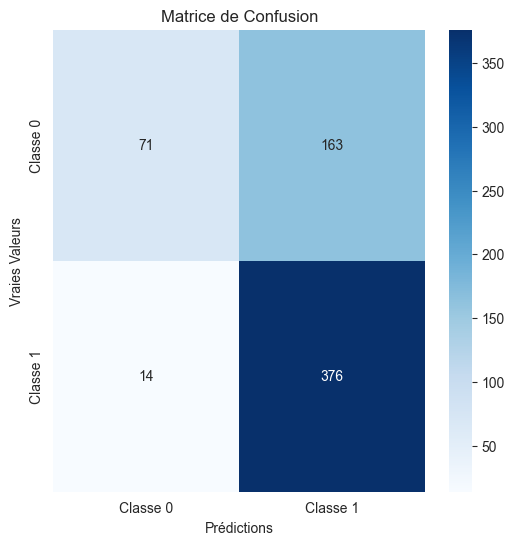

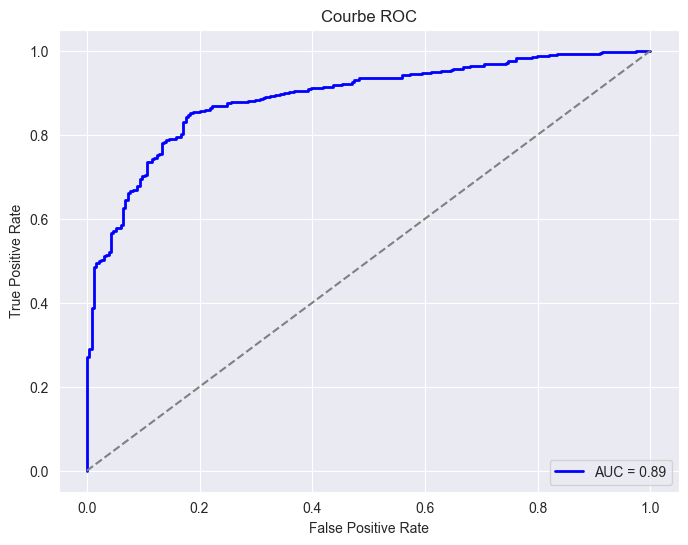

<Figure size 640x480 with 0 Axes>

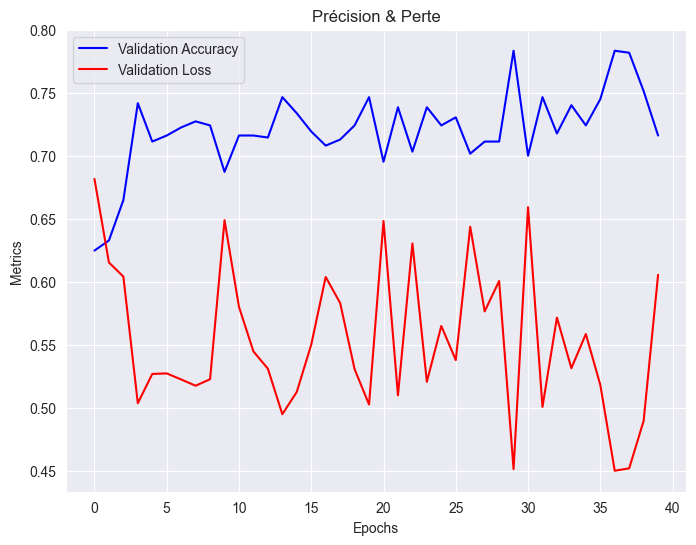

<Figure size 640x480 with 0 Axes>

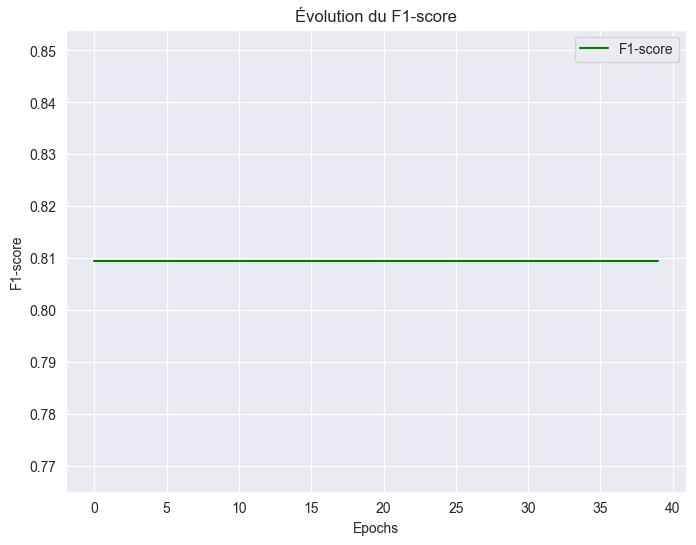

<Figure size 640x480 with 0 Axes>

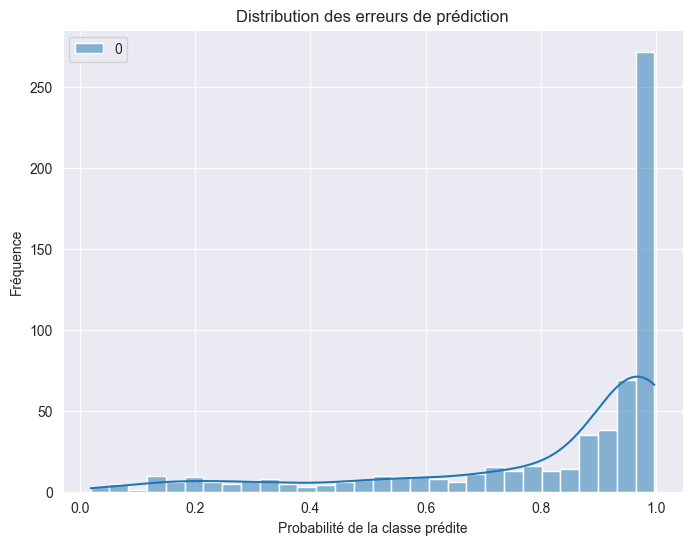

<Figure size 640x480 with 0 Axes>

2025/05/27 09:52:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/27 09:52:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle ResNet50 évalué et résultats enregistrés dans MLflow.


In [34]:
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score

# Nom de l'expérience
experiment_name = "ResNet50 test 1"
client = mlflow.tracking.MlflowClient()

# Vérifier si l'expérience existe déjà
existing_experiments = client.search_experiments()
experiment_id = None

for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Si l'expérience n'existe pas, la créer
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Expérience '{experiment_name}' créée.")
else:
    print(f"Expérience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# Définir l'expérience active
mlflow.set_experiment(experiment_name)

# Chargement du modèle ResNet50 pré-entraîné
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
prediction = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Évaluation du modèle sur les données de test
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)

# Récupération des valeurs maximales et minimales
max_accuracy = max(history.history["val_accuracy"])
min_loss = min(history.history["val_loss"])

# Prédictions sur le jeu de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_prob = model.predict(X_test)

# Calcul des métriques avancées
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# **Ajout de mlflow.end_run() pour éviter les conflits**
mlflow.end_run()

# Sauvegarde des métriques dans MLflow
with mlflow.start_run(run_name="Résultats Test ResNet50"):
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("max_validation_accuracy", max_accuracy)
    mlflow.log_metric("min_validation_loss", min_loss)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", roc_auc)

# Matrice de confusion
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Valeurs")
plt.title("Matrice de Confusion")
mlflow.log_figure(plt.figure(1), "conf_matrix.png")
plt.show()

# Courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
mlflow.log_figure(plt.figure(2), "roc_curve.png")
plt.show()

# Courbe de précision et rappel
plt.figure(figsize=(8, 6))
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Précision & Perte")
plt.legend()
mlflow.log_figure(plt.figure(3), "precision_loss_curve.png")
plt.show()

# Courbe du F1-score
plt.figure(figsize=(8, 6))
plt.plot(range(len(history.history["val_accuracy"])), [f1] * len(history.history["val_accuracy"]), label="F1-score", color="green")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("Évolution du F1-score")
plt.legend()
mlflow.log_figure(plt.figure(4), "f1_score_curve.png")
plt.show()

# Distribution des erreurs de prédiction
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=30, kde=True, color="blue")
plt.xlabel("Probabilité de la classe prédite")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs de prédiction")
mlflow.log_figure(plt.figure(5), "error_distribution.png")
plt.show()

# Sauvegarde du modèle
mlflow.keras.log_model(model, "ResNet50_Test")

print("Modèle ResNet50 évalué et résultats enregistrés dans MLflow.")


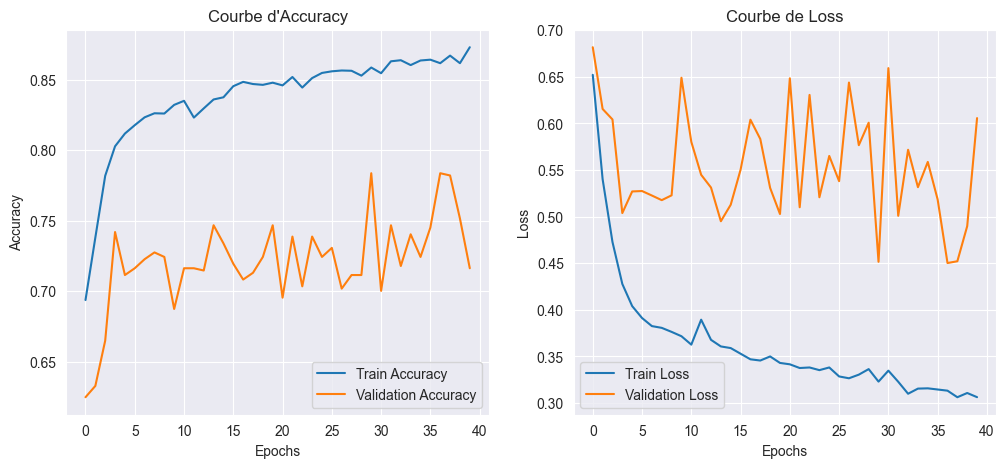

In [35]:
import matplotlib.pyplot as plt

# Récupération des valeurs d'accuracy et de loss
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Création des graphiques
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Courbe d'Accuracy")

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Courbe de Loss")

# Affichage des graphiques
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.8830 - loss: 0.2638
Loss sur les données de test : 0.605775773525238
Accuracy sur les données de test : 0.7163461446762085
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step


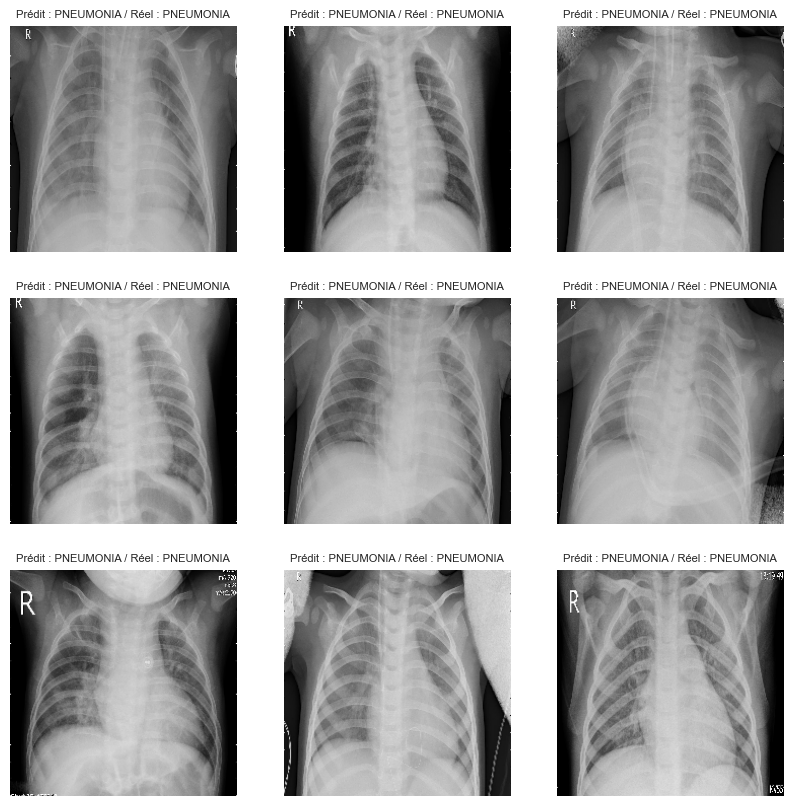

In [36]:
# Évaluation du modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=64)

# Affichage des performances sur l'ensemble de test
print(f"Loss sur les données de test : {test_loss}")
print(f"Accuracy sur les données de test : {test_accuracy}")

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Conversion des probabilités en classes binaires
y_pred_classes = (y_pred > 0.9).astype("int")  # Seuil fixé à 0.9

# Sélectionner uniquement les images prédites comme PNEUMONIE ET qui sont réellement des PNEUMONIA
indices_pneumonia = np.where((y_pred_classes == 1) & (y_test == 1))[0]

# Vérifier si des indices_pneumonia ont été détectés
if len(indices_pneumonia) == 0:
    print("⚠ Aucun cas de pneumonie  détecté avec le seuil actuel.")
else:
    # Mélange aléatoire des indices des PNEUMONIE détectés
    np.random.shuffle(indices_pneumonia)
    indices_a_afficher = indices_pneumonia[:9]  # Sélectionne jusqu'à 9 images aléatoirement

    # Création d'un affichage en grille 3x3 pour montrer quelques images de test et leurs prédictions.
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(len(indices_a_afficher)):
        idx = indices_a_afficher[i]
        axes[i].imshow(X_test[idx])  # Affichage de l'image de test
        axes[i].axis("off")

        label = "PNEUMONIA" if y_pred_classes[idx] == 1 else "NORMAL"
        true_label = "PNEUMONIA" if y_test[idx] == 1 else "NORMAL"

        # Affichage du titre de l'image indiquant la prédiction et la réalité.
        axes[i].set_title(f"Prédit : {label} / Réel : {true_label}", fontsize=8)

    # Masquer les cases vides si moins de 9 images sont affichées
    for i in range(len(indices_a_afficher), 9):
        axes[i].axis("off")

    plt.show()


##### modèle Xception

In [37]:
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [38]:
# Directory containing the "Train" folder
directory = "chest_xray/train"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [ ]:
df_train

In [39]:
# Directory containing the "Train" folder
directory = "chest_xray/test"

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [40]:
df_test.sample(5)

,filepath,label
65,chest_xray/test/PNEUMONIA/person74_virus_135.jpeg,PNEUMONIA
265,chest_xray/test/PNEUMONIA/person30_virus_69.jpeg,PNEUMONIA
507,chest_xray/test/NORMAL/NORMAL2-IM-0251-0001.jpeg,NORMAL
211,chest_xray/test/PNEUMONIA/person131_bacteria_6...,PNEUMONIA
253,chest_xray/test/PNEUMONIA/person121_bacteria_5...,PNEUMONIA


In [41]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [42]:
data_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [43]:
# Extraction des noms de classes depuis les ensembles de données
train_labels = train_ds.class_names  # Étiquettes des données d'entraînement
test_labels = test_ds.class_names  # Étiquettes des données de test
validation_labels = validation_ds.class_names  # Étiquettes des données de validation

# Encodage des étiquettes

# Définition des classes présentes dans l'ensemble de données
class_labels = ['NORMAL', 'PNEUMONIA']  # Deux catégories : cas normaux et cas de pneumonie

# Instanciation du encodeur de labels
label_encoder = LabelEncoder()  # Outil permettant de convertir les étiquettes textuelles en valeurs numériques

# Entraînement de l'encodeur sur les classes définies
label_encoder.fit(class_labels)

# Transformation des étiquettes en valeurs numériques pour l'ensemble d'entraînement
train_labels_encoded = label_encoder.transform(train_labels)

# Transformation des étiquettes en valeurs numériques pour l'ensemble de validation
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transformation des étiquettes en valeurs numériques pour l'ensemble de test
test_labels_encoded = label_encoder.transform(test_labels)


In [44]:
# Boucle sur les lots d'images et leurs étiquettes dans l'ensemble d'entraînement
for image_batch, labels_batch in train_ds:
    # Affichage de la forme du batch d'images
    print("Shape of X_train: ", image_batch.shape)  # Donne la structure du lot d'images
    # Affichage de la forme du batch d'étiquettes
    print("Shape of y_train: ", labels_batch.shape)  # Donne la structure des étiquettes associées
    break  # Arrête la boucle après le premier lot


Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [45]:
# Normalisation des images dans l'ensemble d'entraînement
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))

# Normalisation des images dans l'ensemble de validation
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

# Normalisation des images dans l'ensemble de test
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

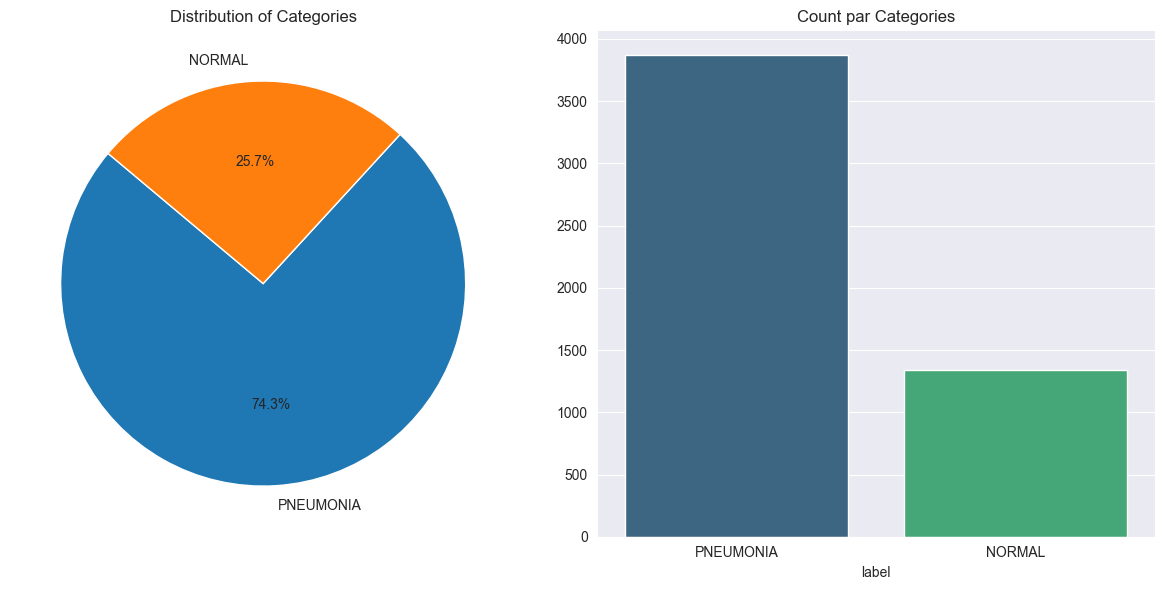

In [46]:
# Comptage du nombre d'occurrences de chaque catégorie dans la colonne 'label' du dataframe d'entraînement
count = df_train['label'].value_counts()

# Création d'une figure contenant deux sous-graphiques (pie chart et bar chart)
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Définition d'une palette de couleurs pour les graphiques
palette = sns.color_palette("viridis")  # Sélectionne une palette de couleurs "viridis"
sns.set_palette(palette)  # Applique cette palette aux visualisations Seaborn

# Création d'un diagramme circulaire (pie chart) sur le premier sous-graphique
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution des Catégories')  # Titre du graphique

# Création d'un diagramme en barres sur le deuxième sous-graphique
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Nombre d’échantillons par catégorie')  # Titre du graphique

# Ajustement automatique de la disposition des sous-graphiques pour éviter les chevauchements
plt.tight_layout()

# Affichage des graphiques
plt.show()

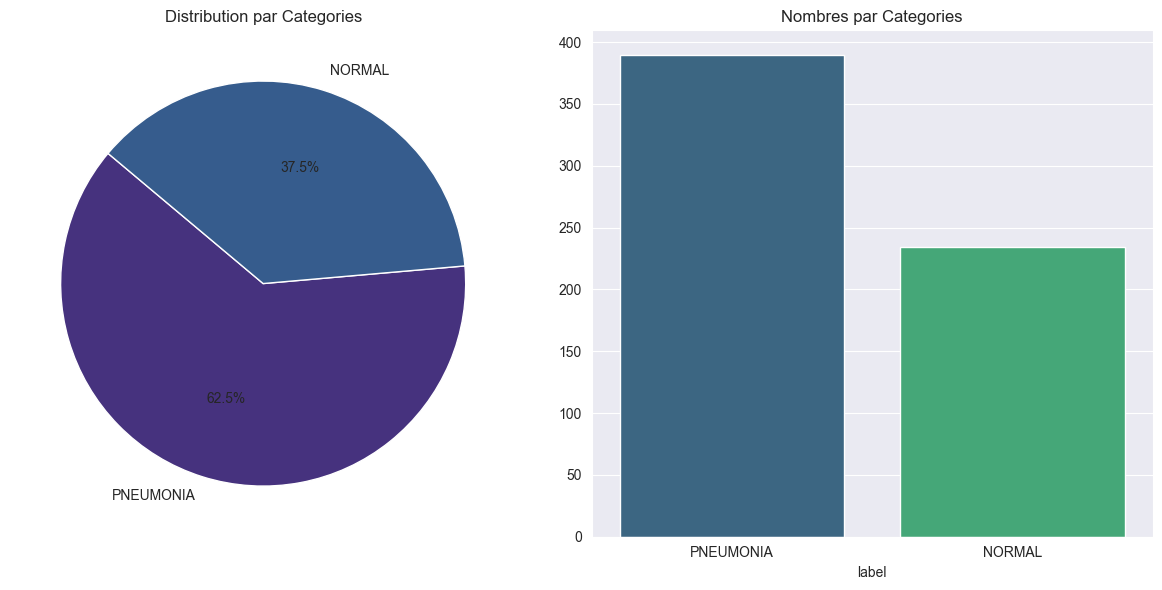

In [47]:
# Comptage du nombre d'occurrences de chaque catégorie dans la colonne 'label' du dataframe de test
count = df_test['label'].value_counts()

# Création d'une figure contenant deux sous-graphiques (pie chart et bar chart)
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')  # Deux sous-graphiques côte à côte

# Définition d'une palette de couleurs pour les graphiques
palette = sns.color_palette("viridis")  # Utilisation de la palette "viridis"
sns.set_palette(palette)  # Application de cette palette aux visualisations Seaborn

# Création d'un diagramme circulaire (pie chart) sur le premier sous-graphique
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)  # Ajout des pourcentages
axs[0].set_title('Distribution par Catégories')  # Titre du graphique

# Création d'un diagramme en barres sur le deuxième sous-graphique
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")  # Affichage du nombre d'occurrences
axs[1].set_title('Nombre d’échantillons par catégorie')  # Titre du graphique

# Ajustement automatique de la disposition des sous-graphiques pour éviter les chevauchements
plt.tight_layout()

# Affichage des graphiques
plt.show()

In [48]:
def visualize_images(path, num_images=5):
    """
    Fonction pour afficher un certain nombre d'images d'un dossier spécifié.

    :param path: Chemin du dossier contenant les images.
    :param num_images: Nombre d'images à afficher (par défaut 5).
    """

    # Obtenir la liste des fichiers d'images dans le dossier spécifié
    image_filenames = os.listdir(path)

    # Limiter le nombre d'images à afficher si le dossier en contient moins que num_images
    num_images = min(num_images, len(image_filenames))

    # Création d'une figure avec plusieurs sous-plots pour afficher les images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')

    # Boucle pour parcourir les images sélectionnées et les afficher
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Construction du chemin complet de l'image
        image_path = os.path.join(path, image_filename)

        # Chargement de l'image avec Matplotlib
        image = mpimg.imread(image_path)

        # Affichage de l'image
        axes[i].imshow(image)  # Afficher l'image
        axes[i].axis('off')  # Désactiver l'affichage des axes
        axes[i].set_title(image_filename)  # Définir le nom du fichier comme titre

    # Ajustement automatique de la disposition pour éviter les chevauchements
    plt.tight_layout()

    # Affichage de la figure
    plt.show()

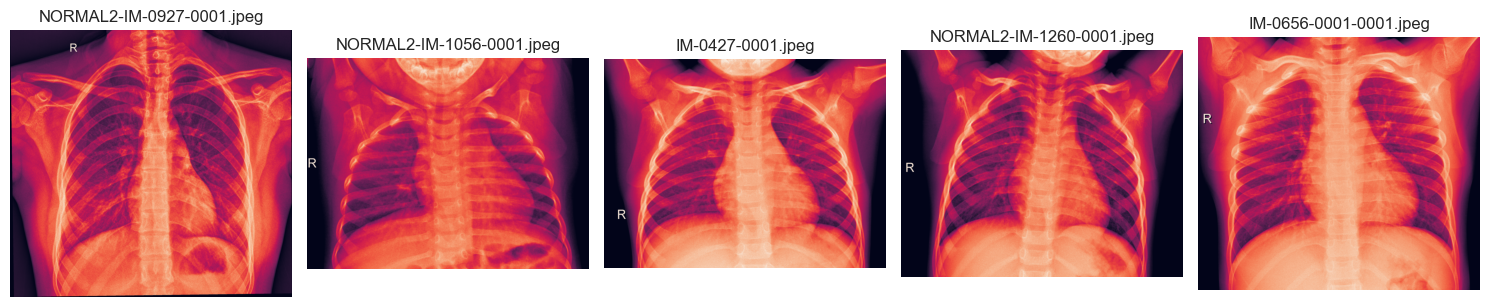

In [49]:
#### Images Normal sans pneumonie
path_to_visualize = "chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

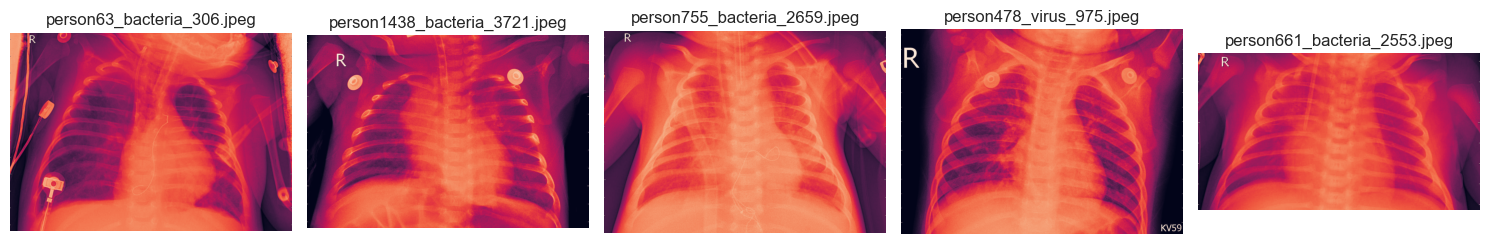

In [50]:
#### Images Pneumonia avec pneumonie
path_to_visualize = "chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [51]:
# Importation du modèle Xception pré-entraîné depuis Keras
from keras.src.applications.xception import Xception

# Chargement du modèle Xception sans la couche de classification finale (include_top=False)
# - weights='imagenet' : Utilise les poids pré-entraînés sur ImageNet
# - include_top=False : Supprime les couches finales de classification pour permettre la personnalisation
# - pooling='avg' : Ajoute un pooling global afin de réduire la taille des features extraites
# - input_shape=(256, 256, 3) : Spécifie la taille des images en entrée (256x256, avec 3 canaux RVB)
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Geler les couches du modèle pré-entraîné pour éviter de modifier ses poids durant l'apprentissage
base_model.trainable = False

# Construction du modèle personnalisé
model = Sequential()

# Ajout du modèle Xception comme base du modèle
model.add(base_model)

# Ajout d'une couche de normalisation pour stabiliser l'entraînement
model.add(BatchNormalization())

# Ajout d'une couche de dropout (probabilité de désactivation de 45%)
model.add(Dropout(0.45))

# Ajout d'une première couche dense (220 neurones, activation ReLU)
model.add(Dense(220, activation='relu'))

# Ajout d'une seconde couche de dropout pour éviter le sur-apprentissage
model.add(Dropout(0.25))

# Ajout d'une deuxième couche dense (60 neurones, activation ReLU)
model.add(Dense(60, activation='relu'))

# Ajout de la couche de sortie avec activation sigmoïde pour classification binaire
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
# - Optimiseur : Adamax avec un taux d'apprentissage de 0.001 (adaptatif et stable)
# - Fonction de perte : binary_crossentropy (adaptée aux problèmes de classification binaire)
# - Métrique : précision ('accuracy') pour suivre la performance
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle : architecture et nombre de paramètres entraînables
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,333,773 (81.38 MB)

 Trainable params: 468,197 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

✅ Expérience 'Xception Classifier Extension' existante, utilisation de l'ID 995093069502134072.
Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.8219 - loss: 0.5518 - val_accuracy: 0.9290 - val_loss: 0.1650
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step - accuracy: 0.9010 - loss: 0.2838 - val_accuracy: 0.9539 - val_loss: 0.1042
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9049 - loss: 0.3025 - val_accuracy: 0.9674 - val_loss: 0.0764
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.9212 - loss: 0.2353 - val_accuracy: 0.9578 - val_loss: 0.0905
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.9224 - loss: 0.2442 - val_accuracy: 0.9616 - val_loss: 0.0925
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step - accuracy: 0.9282 - loss: 0.2074 - val_accuracy: 0.9693 - val_loss: 0.0786
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.9208 - loss: 0.2251 - val_accuracy: 0.9808 - val_

2025-05-27 11:55:46.810968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


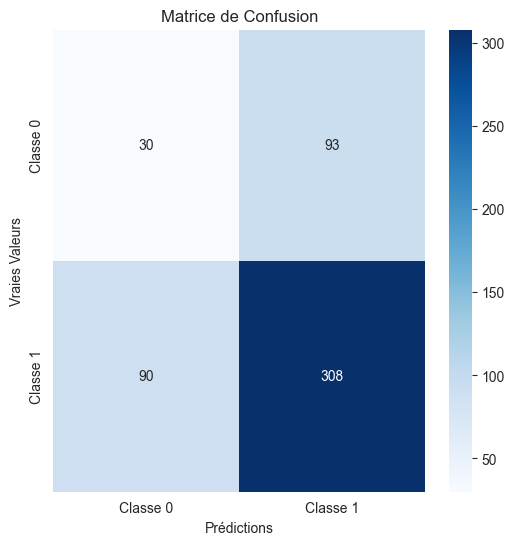

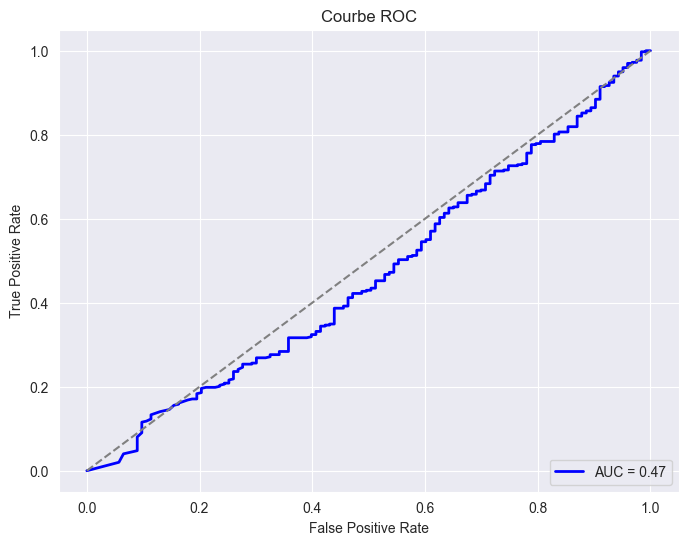

<Figure size 640x480 with 0 Axes>

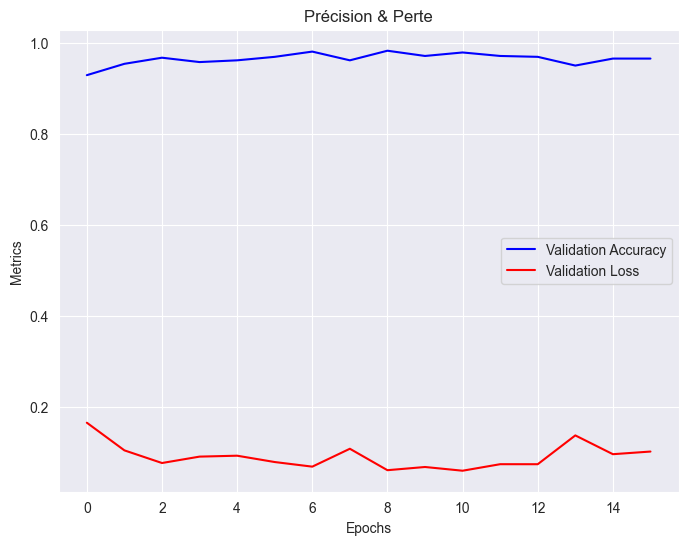

<Figure size 640x480 with 0 Axes>

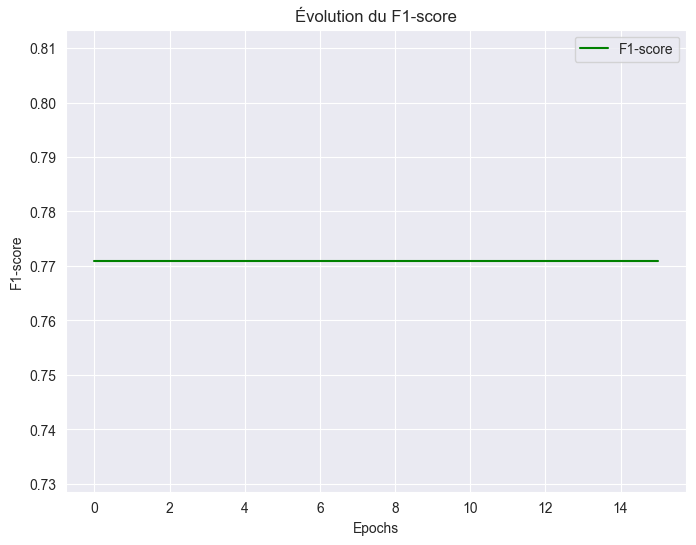

<Figure size 640x480 with 0 Axes>

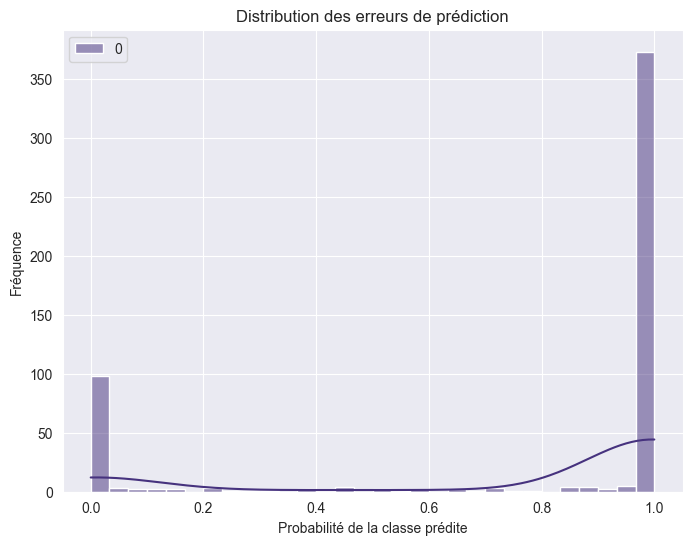

<Figure size 640x480 with 0 Axes>

2025/05/27 11:55:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/27 11:56:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏆 Meilleure précision atteinte : 0.9827
📉 Perte minimale atteinte : 0.0595


In [60]:
# Importation des bibliothèques nécessaires
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from keras.src.applications.xception import Xception

# Définition du nom de l'expérience MLflow
experiment_name = "Xception Classifier Extension"
client = mlflow.tracking.MlflowClient()

# Vérification si l'expérience existe déjà
existing_experiments = client.search_experiments()
experiment_id = None

for exp in existing_experiments:
    if exp.name == experiment_name:
        experiment_id = exp.experiment_id
        break

# Création de l'expérience si elle n'existe pas
if experiment_id is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"🆕 Expérience '{experiment_name}' créée.")
else:
    print(f"✅ Expérience '{experiment_name}' existante, utilisation de l'ID {experiment_id}.")

# Définir l'expérience active dans MLflow
mlflow.set_experiment(experiment_name)

# Paramètres du modèle
epochs = 20
batch_size = 15
dense_units = 220
dropout_rate = 0.45
learning_rate = 0.001

# Chargement du modèle Xception pré-entraîné
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))
base_model.trainable = False

# Construction du modèle
model = Sequential([
    base_model,
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(dense_units, activation='relu'),
    Dropout(0.25),
    Dense(60, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle
model.compile(optimizer=Adamax(learning_rate=learning_rate), loss='binary_crossentropy', metrics=["accuracy"])

# Définition d'un mécanisme d'arrêt anticipé
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# **Ajout de mlflow.end_run() pour éviter les conflits**
mlflow.end_run()

# Enregistrement de l'expérience MLflow
with mlflow.start_run(run_name="Résultats Test Xception Extension"):
    history = model.fit(
        train_ds,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_ds,
        callbacks=[early_stopping],
        verbose=1
    )

    test_loss, test_accuracy = model.evaluate(validation_ds, batch_size=batch_size)

    max_accuracy = max(history.history["val_accuracy"])
    min_loss = min(history.history["val_loss"])

    # Extraction correcte des vraies étiquettes du jeu de validation
    true_labels = np.concatenate([y.numpy() for _, y in validation_ds], axis=0)

    # Prédictions sur le jeu de test
    y_pred = (model.predict(validation_ds) > 0.5).astype("int32")
    y_prob = model.predict(validation_ds)

    # Calcul des métriques avancées
    precision = precision_score(true_labels, y_pred)
    recall = recall_score(true_labels, y_pred)
    f1 = f1_score(true_labels, y_pred)

    # Courbe ROC
    fpr, tpr, _ = roc_curve(true_labels, y_prob)
    roc_auc = auc(fpr, tpr)

    # Sauvegarde des métriques dans MLflow
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("max_validation_accuracy", max_accuracy)
    mlflow.log_metric("min_validation_loss", min_loss)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("auc_roc", roc_auc)

    # Matrice de confusion
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrix(true_labels, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies Valeurs")
    plt.title("Matrice de Confusion")
    mlflow.log_figure(plt.figure(1), "conf_matrix.png")
    plt.show()

    # Courbe ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    mlflow.log_figure(plt.figure(2), "roc_curve.png")
    plt.show()

    # Courbe de précision et rappel
    plt.figure(figsize=(8, 6))
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="blue")
    plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Précision & Perte")
    plt.legend()
    mlflow.log_figure(plt.figure(3), "precision_loss_curve.png")
    plt.show()

    # Courbe du F1-score
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(history.history["val_accuracy"])), [f1] * len(history.history["val_accuracy"]), label="F1-score", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("F1-score")
    plt.title("Évolution du F1-score")
    plt.legend()
    mlflow.log_figure(plt.figure(4), "f1_score_curve.png")
    plt.show()

    # Distribution des erreurs de prédiction
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob, bins=30, kde=True, color="blue")
    plt.xlabel("Probabilité de la classe prédite")
    plt.ylabel("Fréquence")
    plt.title("Distribution des erreurs de prédiction")
    mlflow.log_figure(plt.figure(5), "error_distribution.png")
    plt.show()

    # Sauvegarde du modèle
    mlflow.keras.log_model(model, "Xception_Extension")

# Récupération des valeurs maximales et minimales
max_accuracy = max(history.history["val_accuracy"])
min_loss = min(history.history["val_loss"])

# Sauvegarde des métriques dans MLflow
mlflow.log_metric("max_validation_accuracy", max_accuracy)
mlflow.log_metric("min_validation_loss", min_loss)

# Affichage des résultats
print(f"🏆 Meilleure précision atteinte : {max_accuracy:.4f}")
print(f"📉 Perte minimale atteinte : {min_loss:.4f}")

In [61]:
# Évaluation des performances du modèle sur l'ensemble de validation
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Affichage de la perte et de la précision obtenues sur l'ensemble de validation
print("Validation Loss:", validation_loss)  # Affiche la perte (erreur du modèle)
print("Validation Accuracy:", validation_accuracy)  # Affiche la précision de classification

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.9796 - loss: 0.0467
Validation Loss: 0.05946784093976021
Validation Accuracy: 0.9788867831230164


In [62]:
# Évaluation du modèle sur le dataset de test
test_loss, test_accuracy = model.evaluate(test_ds)

# Affichage des résultats en pourcentage
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8232 - loss: 0.6588
Test Loss: 0.7615131735801697
Test Accuracy: 81.57%


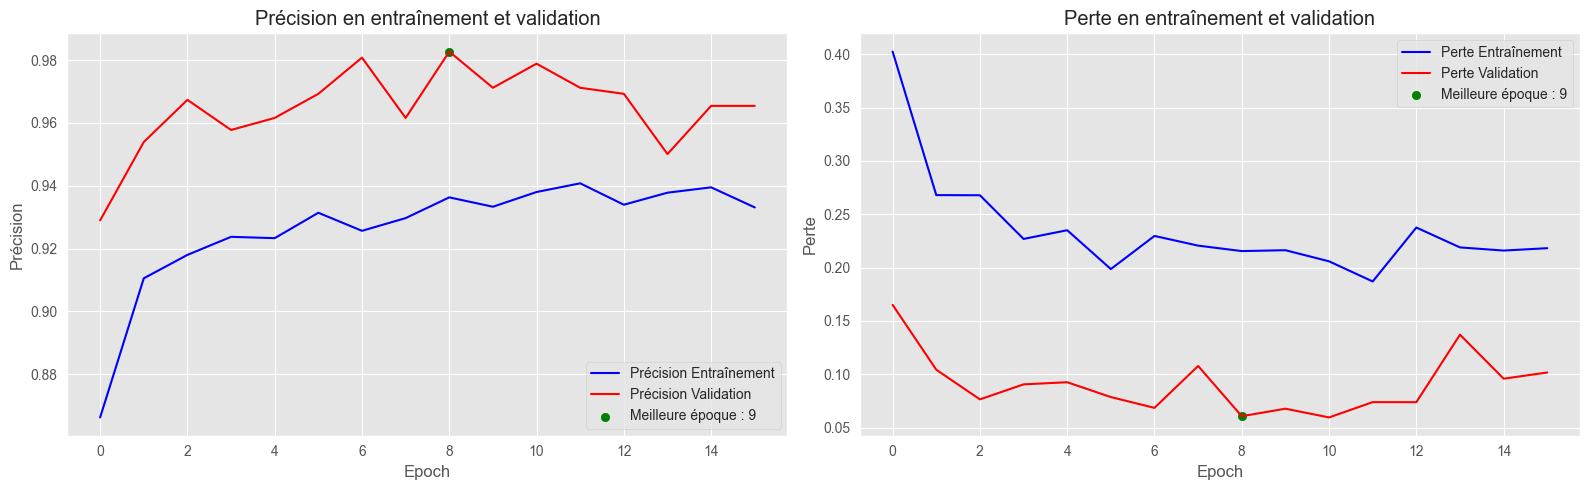

In [63]:
# Trouver le numéro de la meilleure époque (epoch) où la précision de validation est maximale
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Définir le style de fond pour les graphiques
plt.style.use('ggplot')  # Utilisation d'un style valide pour matplotlib

# Création d'une figure avec 2 sous-graphiques (subplots)
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# 📊 Tracé de la précision (accuracy) en entraînement et en validation
axs[0].plot(history.history['accuracy'], label='Précision Entraînement', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Précision Validation', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green',
               label=f'Meilleure époque : {best_epoch}')  # Marquage du meilleur epoch
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Précision')
axs[0].set_title('Précision en entraînement et validation')
axs[0].legend()  # Affichage de la légende

# 📉 Tracé de la perte (loss) en entraînement et en validation
axs[1].plot(history.history['loss'], label='Perte Entraînement', color='blue')
axs[1].plot(history.history['val_loss'], label='Perte Validation', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',
               label=f'Meilleure époque : {best_epoch}')  # Marquage du meilleur epoch
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perte')
axs[1].set_title('Perte en entraînement et validation')
axs[1].legend()  # Affichage de la légende

# 📏 Ajustement de la mise en page pour éviter le chevauchement
plt.tight_layout()

# 🖼️ Affichage du graphique final
plt.show()


Chargement des images de test...
Found 624 files belonging to 2 classes.
Affichage des prédictions sur 20 images aléatoires du dataset de test...


2025-05-27 12:05:22.701496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step


2025-05-27 12:05:27.407886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


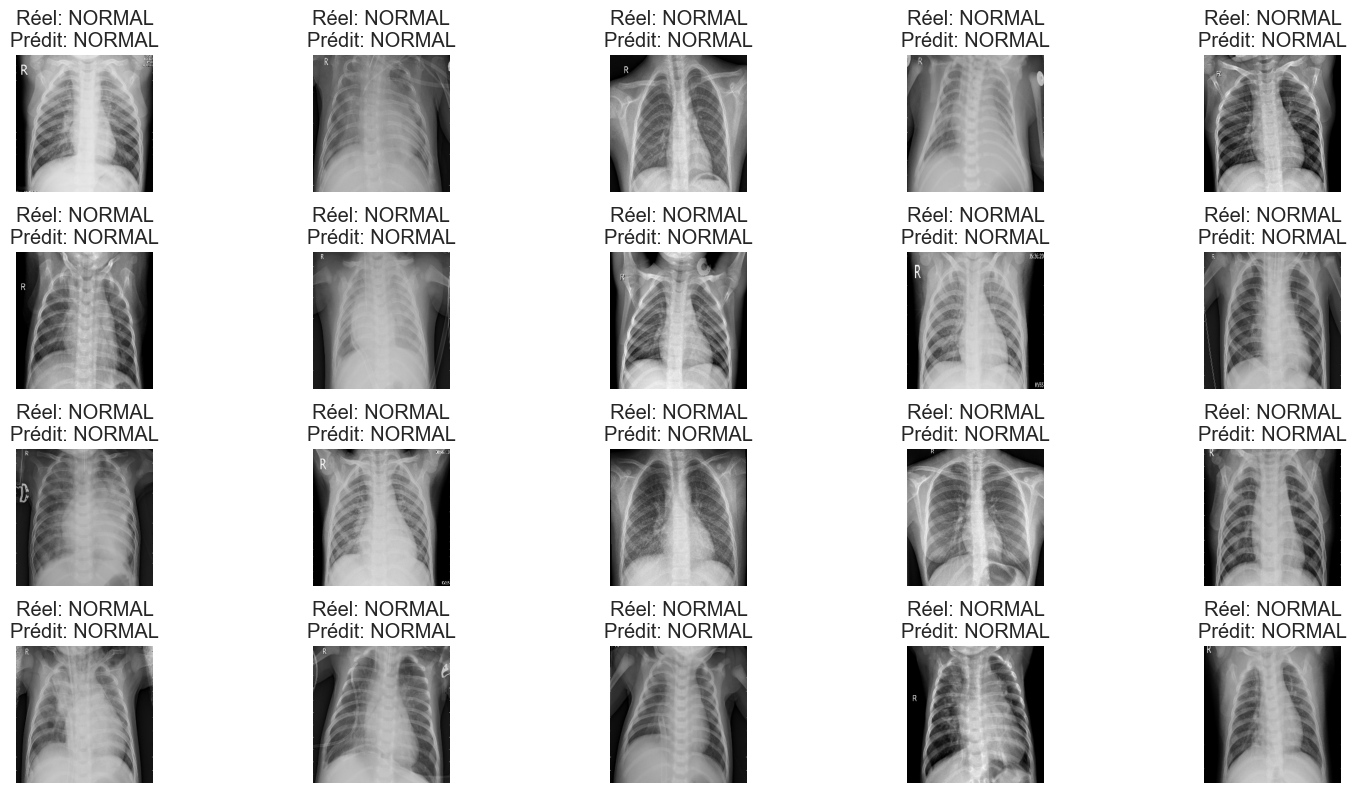

In [64]:
# Définition du chemin vers le dossier contenant les images de test
test_dir = 'chest_xray/test/'
print('Chargement des images de test...')

# Chargement du dataset d'images depuis le dossier spécifié
# - `seed=123` assure que les images sont toujours chargées dans le même ordre
# - `image_size=IMAGE_SIZE` redimensionne toutes les images à la taille souhaitée
# - `batch_size=32` définit le nombre d'images traitées simultanément
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(256, 256),  # Assurez-vous que IMAGE_SIZE est bien défini
    batch_size=32
)

# Définition d'une fonction pour afficher les images avec leurs prédictions
def plot_images_with_predictions(model, dataset, class_labels, num_images=20, num_images_per_row=5):
    """
    Cette fonction affiche un ensemble d'images avec leur **classe réelle** et **classe prédite**.
    Elle prend :
    - `model` : Le modèle de deep learning entraîné
    - `dataset` : Le dataset contenant les images à prédire
    - `class_labels` : Les noms des classes (ex: ['NORMAL', 'PNEUMONIA'])
    - `num_images` : Le nombre total d'images à afficher
    - `num_images_per_row` : Nombre d'images par ligne pour la mise en forme
    """

    # Vérifier que le dataset contient suffisamment d'images
    dataset_list = list(dataset.as_numpy_iterator())  # Convertir le dataset en liste
    if len(dataset_list) == 0:
        print("Erreur : le dataset est vide !")
        return

    # Mélange le dataset pour éviter l'ordre fixe
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset_list))

    # Génération des prédictions
    predictions = model.predict(dataset_shuffled.take(num_images))

    # Création de la figure pour afficher les images
    plt.figure(figsize=(15, 10))

    img_counter = 0  # Compteur pour suivre le nombre d'images affichées

    for images, labels in dataset_shuffled.take(num_images):
        images = images.numpy()  # Convertir Tensor en NumPy

        for j in range(len(images)):  # Parcours des images dans le batch
            if img_counter < num_images:  # S'assurer que l'on ne dépasse pas le nombre d'images souhaité
                predicted_class = class_labels[np.argmax(predictions[img_counter])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, img_counter + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'Réel: {true_class}\nPrédit: {predicted_class}')
                plt.axis('off')

                img_counter += 1  # Incrémenter le compteur

    plt.tight_layout()
    plt.show()

# Affichage des images avec leurs prédictions
print('Affichage des prédictions sur 20 images aléatoires du dataset de test...')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


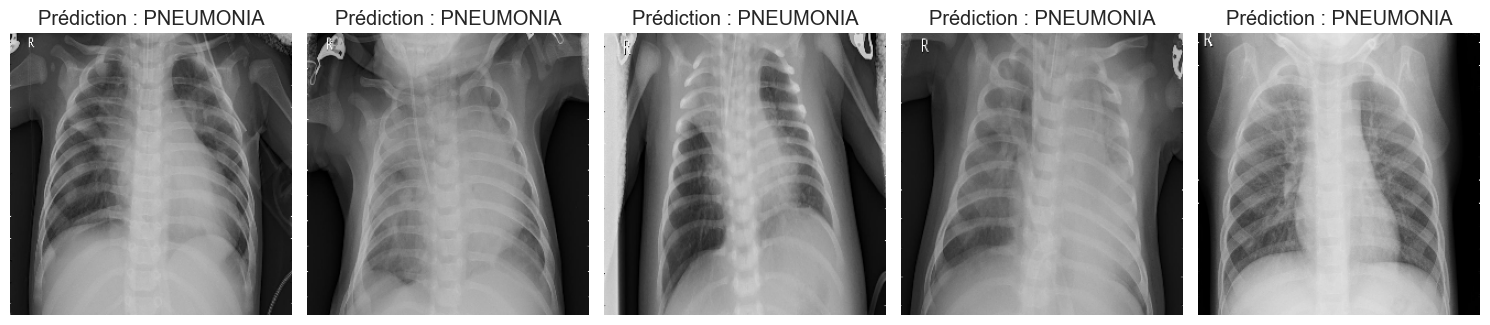

In [65]:
# Définition du chemin du dossier contenant les images de test
directory_path = 'chest_xray/test/PNEUMONIA/'

# Sélectionner les N premières images du dossier (ici, 5 images)
image_files = os.listdir(directory_path)[:5]

# Création d'une figure avec plusieurs sous-graphiques pour afficher les images
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))  # Une ligne avec autant d'images que sélectionnées

# Boucle pour charger, prétraiter et prédire les images sélectionnées
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)  # Construction du chemin complet de l'image

    # Chargement de l'image avec OpenCV
    img = cv2.imread(img_path)

    # Redimensionnement de l'image à la taille requise par le modèle (256x256 pixels)
    img = cv2.resize(img, (256, 256))

    # Normalisation des valeurs des pixels pour les mettre entre 0 et 1
    img_array = img.astype(np.float32) / 255.0

    # Expansion des dimensions pour correspondre aux attentes du modèle (ajout d'une dimension batch)
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une prédiction avec le modèle entraîné
    predictions = model.predict(img_array)

    # Convertir la sortie du modèle en une classe (0 = Normal, 1 = Pneumonie)
    actual_prediction = (predictions > 0.5).astype(int)

    # Affichage de l'image avec l'étiquette prédite
    # Conversion de l'image de BGR (format OpenCV) à RGB pour un affichage correct avec Matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')  # Suppression des axes pour une meilleure lisibilité

    # Définition du titre de l'image selon la prédiction du modèle
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Prédiction : {predicted_label}')

# Ajustement automatique de la disposition des sous-graphiques
plt.tight_layout()

# Affichage final des images avec leurs prédictions
plt.show()